In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data import *
from features import *
from stats import *
from preprocess import *
from model import *
from step import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
import sklearn.linear_model

In [3]:
step = Step(load_odr)
step = Step(gt_n_trials, step, n=8)
# step = Step(subset, step, key='monkey', value='LEM')
step = Step(win_cts_by_trial, step, win_start=1500, win_end=3000, win_stride=150, win_size=150)
step = Step(win_cts_by_win, step)

In [4]:
# cells_to_use = ['LEM-PFC-259', 'LEM-PFC-260', 'LEM-PFC-067', 'LEM-PFC-258',
#        'LEM-PFC-159', 'LEM-PFC-268', 'LEM-PFC-266', 'LEM-PFC-166',
#        'LEM-PPC-087', 'LEM-PFC-014', 'LEM-PFC-244', 'LEM-PFC-167',
#        'LEM-PFC-029', 'LEM-PPC-055', 'LEM-PPC-054', 'LEM-PPC-053',
#        'LEM-PPC-051', 'LEM-PFC-246', 'LEM-PFC-105', 'LEM-PFC-083']
# wcbt = step()['win_cts_by_trial']
# wcbt = wcbt.loc[cells_to_use]
# wcbt = wcbt.reset_index()
# cts = np.stack(wcbt[wcbt.position == 5].win_cts.array)
# cts = cts * 1000 / 50
# cts.shape

In [5]:
cells = step()['cells']
wcbt = step()['win_cts_by_trial']

for c, _ in cells.iterrows():
    # print(c)
    data = wcbt.loc[c].reset_index()
    # print(data)
    lr = sklearn.linear_model.LogisticRegression()
    cts = np.stack(data.win_cts.array)
    cts = cts - cts.mean(axis=0)
    s = cts.std(axis=0)
    s[s == 0] = 1
    cts = cts / s
    lr.fit(cts, data.position)
    yhat = lr.predict(cts)
    data['delta'] = np.abs(data.position - yhat)
    data.delta = np.min(np.vstack([data.delta, 8 - data.delta]), axis=0)
    deltas = data.groupby('position').delta.mean()
    cells.loc[c, 'best_pos'] = deltas.idxmin()
    cells.loc[c, 'best_delta'] = deltas.min()

In [6]:
cells = cells[(cells.best_delta < 0.5) & (cells.monkey != 'YOUNG')]
len(cells)

338

In [7]:
all_df = step()['raw_df']
all_df = all_df.reset_index()
all_df = all_df.join(cells[['best_pos', 'best_delta']], on='cell')

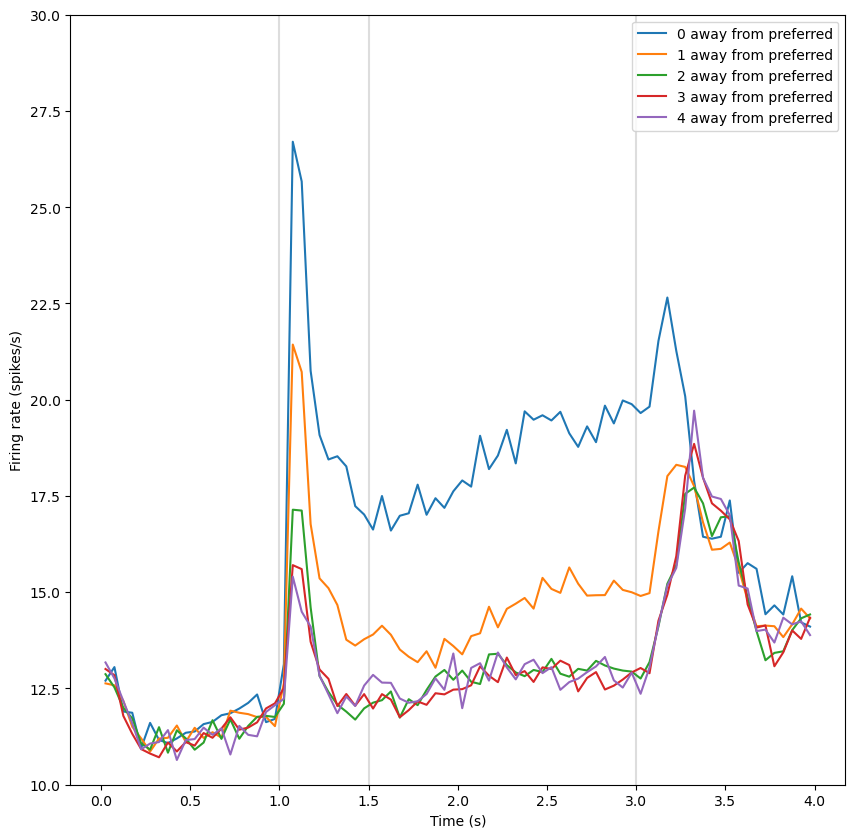

In [8]:
plt.figure(figsize=(10, 10))
for i in range(5):
    low_pos = (all_df.best_pos - i) % 8
    high_pos = (all_df.best_pos + i) % 8
    df = all_df[(all_df.position == low_pos) | (all_df.position == high_pos)]
    # n = df.cell.nunique()
    ts = np.concatenate(df.ts.array)
    ts.sort()
    BIN_WIDTH = 0.05
    bins=np.arange(0, 4 + BIN_WIDTH / 2, BIN_WIDTH)
    ts_array = np.stack([np.histogram(x, bins=bins)[0] for x in df.ts.array])
    x = bins[:-1] + BIN_WIDTH / 2
    # vals = []
    # for i in range(ts_array.shape[1]):
    #     ci = bootstrap((ts_array[:,i],), np.mean, confidence_level=0.95, n_resamples=1000).confidence_interval
    #     vals.append([np.mean(ts_array[:,i]), ci[0], ci[1]])

    # vals = np.array(vals) / BIN_WIDTH
    y = np.mean(ts_array, axis=0) / BIN_WIDTH

    plt.plot(x, y, label=f'{i} away from preferred')
    # plt.plot(x, vals[:,0], label=f'{i} away from preferred')
    # plt.fill_between(x, vals[:,1], vals[:,2], alpha=0.5)

[plt.axvline(x=x, color='#dddddd', zorder=0) for x in [1.0, 1.5, 3.0]]
plt.ylim(10, 30)
plt.ylabel('Firing rate (spikes/s)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

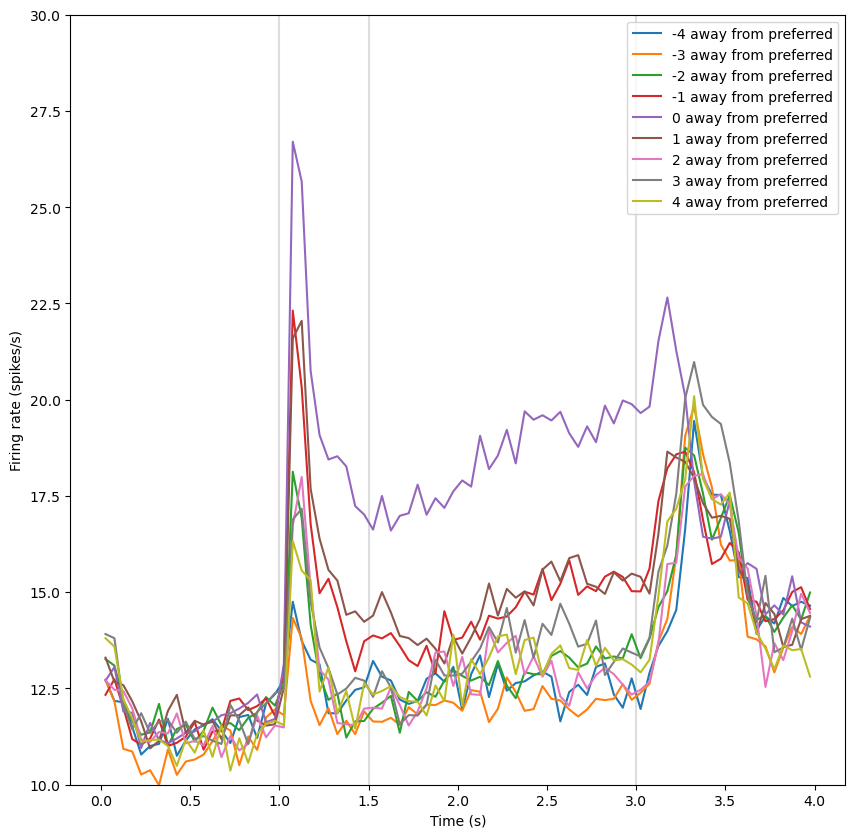

In [9]:
plt.figure(figsize=(10, 10))
for i in range(-4, 5):
    # low_pos = (all_df.best_pos - i) % 8
    # high_pos = (all_df.best_pos + i) % 8
    # df = all_df[(all_df.position == low_pos) | (all_df.position == high_pos)]
    df = all_df[all_df.position == all_df.best_pos + i]
    # n = df.cell.nunique()
    ts = np.concatenate(df.ts.array)
    ts.sort()
    BIN_WIDTH = 0.05
    bins=np.arange(0, 4 + BIN_WIDTH / 2, BIN_WIDTH)
    ts_array = np.stack([np.histogram(x, bins=bins)[0] for x in df.ts.array])
    x = bins[:-1] + BIN_WIDTH / 2
    # vals = []
    # for i in range(ts_array.shape[1]):
    #     ci = bootstrap((ts_array[:,i],), np.mean, confidence_level=0.95, n_resamples=1000).confidence_interval
    #     vals.append([np.mean(ts_array[:,i]), ci[0], ci[1]])

    # vals = np.array(vals) / BIN_WIDTH
    y = np.mean(ts_array, axis=0) / BIN_WIDTH

    plt.plot(x, y, label=f'{i} away from preferred')
    # plt.plot(x, vals[:,0], label=f'{i} away from preferred')
    # plt.fill_between(x, vals[:,1], vals[:,2], alpha=0.5)

[plt.axvline(x=x, color='#dddddd', zorder=0) for x in [1.0, 1.5, 3.0]]
plt.ylim(10, 30)
plt.ylabel('Firing rate (spikes/s)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()